<a href="https://colab.research.google.com/github/DavidPuigV/Cifar10/blob/main/vgg_da_cnn_cifar10_tf2_v0_corregido_por_IR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [ ]:
import numpy as np
import time
import datetime
import random
import pandas as pd
import os

from matplotlib import pyplot as plt
from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

## 1.1. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:** 
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [ ]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0           

In [ ]:
print(y_train)
print(y_test)


[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
[[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]


Obtenemos un array con todas las labels de CIFAR10

In [ ]:
cifar10_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
print('labels: %s' % (cifar10_labels))

labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


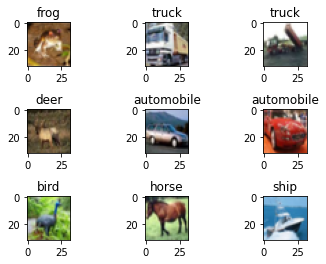

In [ ]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [ ]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)

y_train_encoded = le.transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_train_encoded

array([6, 9, 9, ..., 6, 2, 8])

In [ ]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [6],
       [2],
       [8]], dtype=uint8)

Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución es pera una matriz de 4 campos** (más parecido a "imagenes"), no un array de 3 como son actualmente los data sets de train, test y validación. Así que toca darle al **.reshape()**

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [ ]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))


Train: X=(40000, 32, 32, 3), y=(40000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


# 2. VGG16 Carga de la parte de extraccion de features

In [ ]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))
vgg.summary()

In [ ]:

def_output = vgg.layers[-1].output
new_flatten_layer = ks.layers.Flatten()(def_output)
new_flatten_layer

In [ ]:
gg_model = Model(vgg.input, new_flatten_layer)
vgg_model.summary()

In [ ]:

pd.set_option('max_colwidth', None)                                               # volem congelar els pesos de la xarxa vgg16
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Trainable?'])

In [ ]:
print(vgg_model.trainable)


In [ ]:
vgg_model.trainable = False

for layer in vgg_model.layers:
  layer.trainable = False

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Trainable?'])

In [ ]:
# PREPROCESADO HASTA EL CUELLO DE BOTELLA

def llevar_cuello_botella(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [ ]:
x_train_post_vgg = llevar_cuello_botella(vgg_model, x_train)
x_test_post_vgg = llevar_cuello_botella(vgg_model, x_test)
x_val_post_vgg = llevar_cuello_botella(vgg_model, x_val)

In [ ]:
x_train_post_vgg.shape

In [ ]:
# MONTAMOS RED DE CLASIFICACION

input_shape = vgg_model.output_shape[1]
print(input_shape)

In [ ]:

# ARQUITECTURA CON  VGG16

model_post_vgg = ks.Sequential()

model_post_vgg.add(ks.layers.InputLayer(input_shape=(input_shape,)))
model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.5))  

model.add(ks.layers.Dense(10, activation='softmax'))
model.summary()

In [ ]:
# OPTIMIZADOR DEL VGG

model_post_vgg.compile(optimizer='Adam', loss='SparseCategoricalCrossentropy', metrics=['SparseCategoricalAccuracy'])

## 2. Arquitectura de red del modelo


In [ ]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', input_shape=(32,32,3)))
model.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.5))  

model.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same'))
model.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.5))  

model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same'))
model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Dropout(0.5))  

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.5))  

model.add(ks.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

## 3. Optimizador, función error


In [ ]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 3.1 Definimos la tecnica de Early stopping mediante callbacks

In [ ]:
callback_val_loss = EarlyStopping(monitor="val_loss", patience=20)
callback_val_accy = EarlyStopping(monitor="val_accuracy", patience=20)


# 4. Data Augmentation

### Transformador de imagenes a datos consumibles por la red neuronal


In [ ]:

train_datagen = ImageDataGenerator( 
    rescale=1./255,
    horizontal_flip=True,
    # rotation_range = 10,
    # shear_range = 0.1,
    # zoom_range= 0.1,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # brightness_range=(0.8,1.2),
    # fill_mode='nearest'
    )

train_generator = train_datagen.flow( 
    x_train, 
    y_train_encoded, 
    batch_size=512          # hago esto para cada 30 imagenes
    )  


### vamos a pintarnos un ejemplo de lo que hace el train data generator

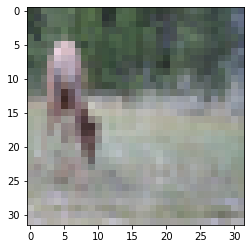

In [ ]:

sample = random.choice(range(0,1450))
example_generator = train_datagen.flow(
    x_train[sample:sample+1],
    y_train[sample:sample+1],
    batch_size=512
    )

plt.imshow(x_train[sample])


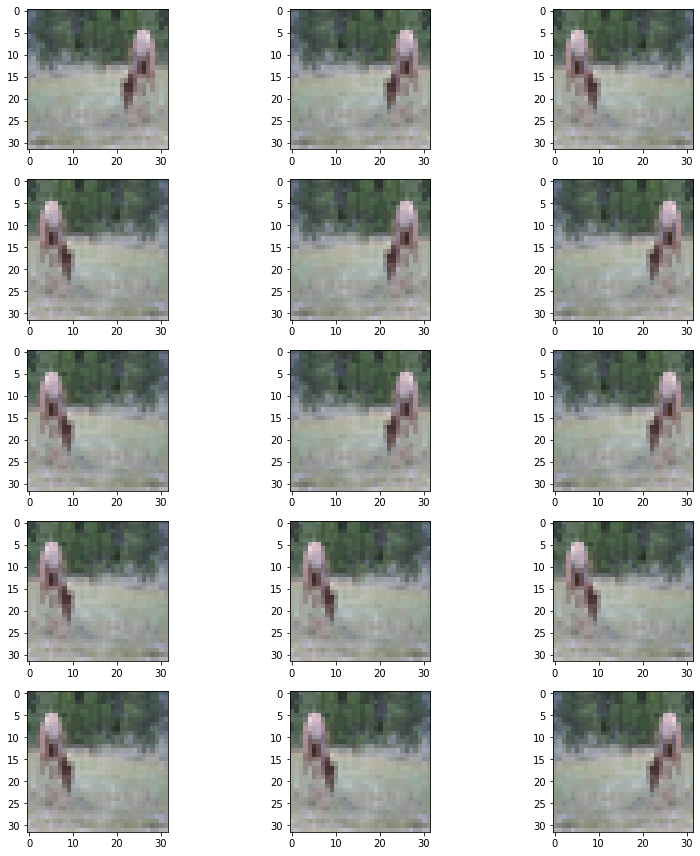

In [ ]:
plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for X, Y in example_generator:
        image = X[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

**De validacion y de testeo**

Fijaos que aquí la única modificación es un re-escalado, nada de modificaciones

In [ ]:

validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val, 
    y_val_encoded, 
    batch_size=512
    )

test_datagen = ImageDataGenerator(
    rescale=1./255
    )
test_generator = test_datagen.flow(
    x_test, 
    y_test_encoded,
    batch_size=512
    )


## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [ ]:
t = time.perf_counter()

In [ ]:
# VGG16
history = model_post_vgg.fit(x_train_post_vgg, y_train, epochs=150, callbacks=[callback_val_loss,callback_val_accy], batch_size= 512, validation_data=(x_val_post_vgg, y_val))

# Data Augmentation
# history = model.fit(train_generator,epochs=100,steps_per_epoch= 78,callbacks=[callback_val_loss,callback_val_accy],validation_data=validation_generator,validation_steps=20)

# Initial
# history = model.fit(x_train, y_train, epochs=200, callbacks=[callback_val_loss,callback_val_accy], batch_size= 512, validation_data=(x_val, y_val))

Epoch 1/100
78/78 [==============================] - 6s 50ms/step - loss: 2.1880 - accuracy: 0.1671 - val_loss: 1.7484 - val_accuracy: 0.3498
Epoch 2/100
78/78 [==============================] - 3s 42ms/step - loss: 1.7292 - accuracy: 0.3484 - val_loss: 1.5499 - val_accuracy: 0.4272
Epoch 3/100
78/78 [==============================] - 3s 43ms/step - loss: 1.5219 - accuracy: 0.4329 - val_loss: 1.3391 - val_accuracy: 0.5040
Epoch 4/100
78/78 [==============================] - 3s 43ms/step - loss: 1.3897 - accuracy: 0.4898 - val_loss: 1.2133 - val_accuracy: 0.5610
Epoch 5/100
78/78 [==============================] - 3s 43ms/step - loss: 1.3070 - accuracy: 0.5242 - val_loss: 1.1960 - val_accuracy: 0.5642
Epoch 6/100
78/78 [==============================] - 3s 43ms/step - loss: 1.2530 - accuracy: 0.5463 - val_loss: 1.1824 - val_accuracy: 0.5730
Epoch 7/100
78/78 [==============================] - 3s 43ms/step - loss: 1.1785 - accuracy: 0.5755 - val_loss: 1.0273 - val_accuracy: 0.6351
Epoch 

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:05:52.100774


## 6. Evaluamos el Modelo

In [ ]:
_, acc = model.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Accuracy:',' %.3f' % (acc))

Accuracy:  0.843


In [ ]:
# Initial
# model.evaluate(x_test, y_test, verbose=0)

# for Data Agumentation
# model.evaluate(x_test, y_test, verbose=0)

# for VGG16
model_post_vgg.evaluate(x_test, y_test, verbose=0)

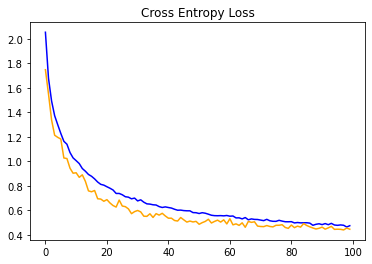

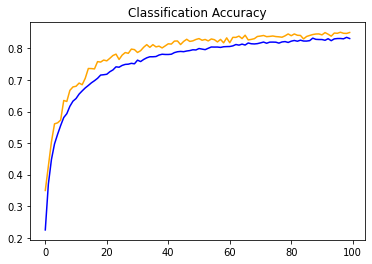

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [ ]:
predictions = model.predict(x_test_scaled)

Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


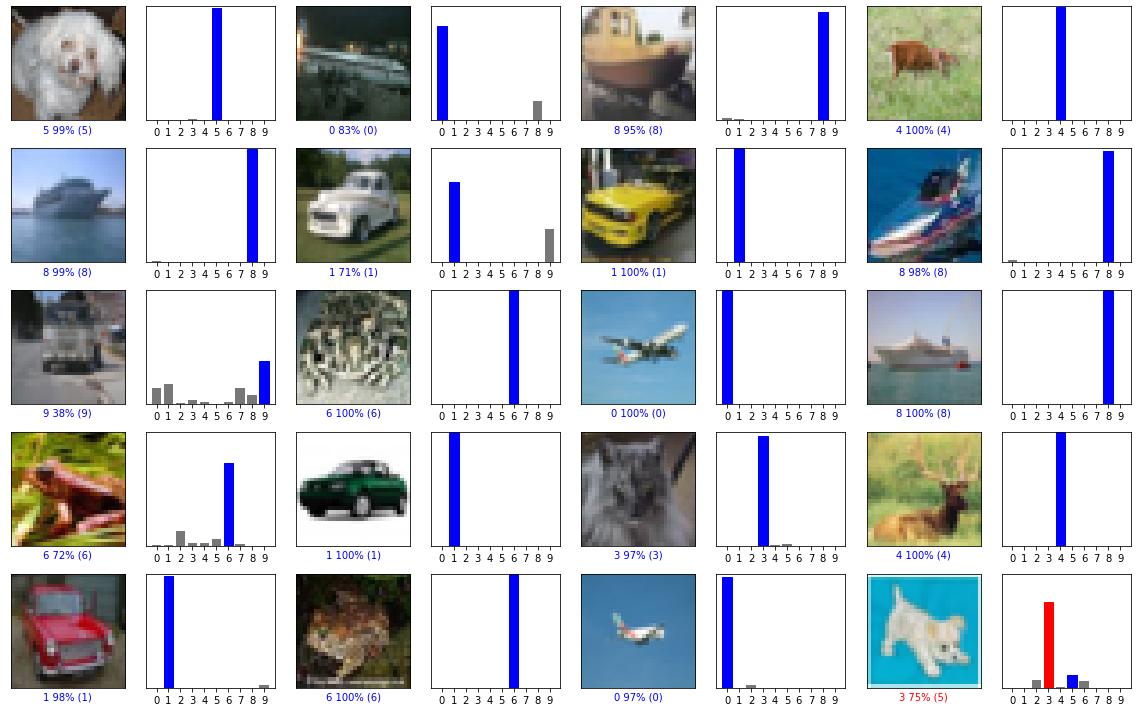

In [ ]:

i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 1000
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test_scaled)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()